# Apply CP to SARS-CoV-2 Serology Dataset

COMPAC/PARAFAC (CP) decompositions of large multidimensional datasets are extremely useful in dimensionality reduction, allowing us to develop models that are both representative and compact while retaining crucial patterns between subjects. One notable example is systems serology, which aims to comprehensively profile the interactions betwen antibodies and receptors of a patients alongside other types of immunological and demographic data. Here, we will apply CP decomposition to profile patients with COVID-19, caused by the virus SARS-CoV-2.

### Import the necessary dependencies and COVID dataset.
This COVID data is made available by Dr. Zohar Oryan via openICPSR. More information can be found at this link: https://www.openicpsr.org/openicpsr/project/123601/version/V1/view;jsessionid=119AF2F4869E19F81552CFB5980808CB

In [1]:
import numpy as np
import pandas as pd
import tensorly as tl
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold

import seaborn as sns
from scipy.stats import sem
from tensorly.decomposition import parafac
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator
from itertools import groupby
from copy import deepcopy

def pbsSubtractOriginal():
    """ Paper Background subtract, will keep all rows for any confusing result. """
    Cov = pd.read_csv("https://raw.githubusercontent.com/meyer-lab/systemsSerology/main/syserol/data/ZoharCovData.csv", index_col=0)
    # 23 (0-> 23) is the start of IgG1_S
    Demographics = Cov.iloc[:, 0:23]
    Serology = Cov.iloc[:, 23::]
    Serology -= Serology.loc["PBS"].values.squeeze()
    df = pd.concat([Demographics, Serology], axis=1)
    df = df.loc[np.isfinite(df["patient_ID"]), :]
    df["week"] = np.array(df["days"] // 7 + 1.0, dtype=int)
    df["patient_ID"] = df["patient_ID"].astype('int32')
    df["group"] = pd.Categorical(df["group"], ["Negative", "Mild", "Moderate", "Severe", "Deceased"])
    df = df.sort_values(by=["group", "days", "patient_ID"])
    return df.reset_index()

pbsSubtractOriginal()

,sample_ID,patient_ID,age,sex,COVID,immunosup,hospitalized,death_COVID,ICU,group,...,FcR2B_NL63,FcR2B_HKU1,FcR2B_flu_mix,FcR3A_NL63,FcR3A_HKU1,FcR3A_flu_mix,FcR3B_NL63,FcR3B_HKU1,FcR3B_flu_mix,week
0,1_43,23,97.0,M,N,0,1,0,0,Negative,...,480149.00,564678.00,1437753.50,61303.00,57279.75,1538409.00,58856.50,56065.25,1010657.50,1
1,4_74,205,21.0,M,N,0,1,0,1,Negative,...,131161.75,157113.00,281237.75,2495.50,2161.50,44651.75,22322.75,39258.50,145088.00,1
2,1_42,23,97.0,M,N,0,1,0,0,Negative,...,21795.00,29419.50,613104.50,176.50,9.25,163417.75,487.50,184.75,100979.25,1
3,4_73,204,36.0,F,N,0,1,0,1,Negative,...,19328.25,7003.25,902298.00,470.25,-83.25,558736.75,908.75,-176.25,393842.00,1
4,1_33,21,64.0,M,N,0,1,0,1,Negative,...,42810.00,7965.50,239633.00,1134.50,304.00,43519.25,3670.50,714.00,150331.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2_76,86,59.0,M,P,0,1,1,1,Deceased,...,253958.25,476045.00,1784936.75,70646.50,178645.25,2263831.50,61810.25,163136.00,1882969.75,5
434,2_77,86,59.0,M,P,0,1,1,1,Deceased,...,70300.50,159378.25,1616044.75,8579.75,24788.50,2055521.00,2952.25,11522.00,1645874.50,5
435,4_36,171,72.0,M,P,0,1,1,0,Deceased,...,86743.75,18985.50,1069527.50,30564.00,574.75,1360522.25,16045.75,758.50,1154776.25,5
436,2_78,86,59.0,M,P,0,1,1,1,Deceased,...,652357.25,916556.75,1947746.50,264073.00,542923.00,2298166.50,173773.00,367417.00,1857548.00,6


### Reshape the data as a 3D tensor.
We remove all other data besides antigen and receptor measurements as well as when these were collected. All measurements are set to a minimum of 10, then mean centered (these transformations do not affect subject patterns).

In [4]:
df = pbsSubtractOriginal()
receptorLabels = ["IgG1","IgG2","IgG3","IgA1","IgA2","IgM","FcRalpha","FcR2A","FcR2B","FcR3A","FcR3B"]
antigenLabels = ["S", "RBD", "N", "S1", "S2", "S1 Trimer"]

tensor = np.full((len(df), len(antigenLabels), len(receptorLabels)), np.nan)
missing = 0

for rii, recp in enumerate(receptorLabels):
    for aii, anti in enumerate(antigenLabels):
        try:
            dfAR = df[recp + "_" + anti]
            tensor[:, aii, rii] = dfAR.values
        except KeyError:
            missing += 1

tensor = np.clip(tensor, 10.0, None)
tensor = np.log10(tensor)

# Mean center each measurement
tensor -= np.nanmean(tensor, axis=0)

### Create functions to normalize factors, sort factors by variance, and reorient factors.
These are necessary to process the tensor factorization after running the CP decomposition and find the components with the greatest variance.
buildGlycan(), totalVar(), and delete_component() are necessary for sorting the factors by variance.

In [6]:
def cp_normalize(tFac):
    """ Normalize the factors using the inf norm. """
    for i, factor in enumerate(tFac.factors):
        scales = np.linalg.norm(factor, ord=np.inf, axis=0)
        tFac.weights *= scales
        if i == 0 and hasattr(tFac, 'mFactor'):
            tFac.mFactor *= scales

        tFac.factors[i] /= scales

    return tFac

def reorient_factors(tFac):
    """ This function ensures that factors are negative on at most one direction. """
    # Flip the subjects to be positive
    rMeans = np.sign(np.mean(tFac.factors[1], axis=0))
    agMeans = np.sign(np.mean(tFac.factors[2], axis=0))
    tFac.factors[0] *= rMeans[np.newaxis, :] * agMeans[np.newaxis, :]
    tFac.factors[1] *= rMeans[np.newaxis, :]
    tFac.factors[2] *= agMeans[np.newaxis, :]

    if hasattr(tFac, 'mFactor'):
        tFac.mFactor *= rMeans[np.newaxis, :] * agMeans[np.newaxis, :]

    return tFac

def sort_factors(tFac):
    """ Sort the components from the largest variance to the smallest. """
    rr = tFac.rank
    tensor = deepcopy(tFac)
    vars = np.array([totalVar(delete_component(tFac, np.delete(np.arange(rr), i))) for i in np.arange(rr)])
    order = np.flip(np.argsort(vars))

    tensor.weights = tensor.weights[order]
    tensor.factors = [fac[:, order] for fac in tensor.factors]
    np.testing.assert_allclose(tl.cp_to_tensor(tFac), tl.cp_to_tensor(tensor))

    if hasattr(tFac, 'mFactor'):
        tensor.mFactor = tensor.mFactor[:, order]
        np.testing.assert_allclose(buildGlycan(tFac), buildGlycan(tensor))

    return tensor

def buildGlycan(tFac):
    return tFac.factors[0] @ tFac.mFactor.T

def totalVar(tFac):
    """ Total variance of a factorization on reconstruction. """
    varr = tl.cp_norm(tFac)
    if hasattr(tFac, 'mFactor'):
        varr += tl.cp_norm((None, [tFac.factors[0], tFac.mFactor]))
    return varr

def delete_component(tFac, compNum):
    """ Delete the indicated component. """
    tensor = deepcopy(tFac)
    compNum = np.array(compNum, dtype=int)

    # Assert that component # don't exceed range, and are unique
    assert np.amax(compNum) < tensor.rank
    assert np.unique(compNum).size == compNum.size

    tensor.rank -= compNum.size
    tensor.weights = np.delete(tensor.weights, compNum)

    if hasattr(tFac, 'mFactor'):
        tensor.mFactor = np.delete(tensor.mFactor, compNum, axis=1)

    tensor.factors = [np.delete(fac, compNum, axis=1) for fac in tensor.factors]
    return tensor

### Run tensorly's parafac() decomposition then normalize the factors.

In [18]:
comps = np.arange(1, 7)

CMTFfacs = [parafac(tensor, cc, tol=1e-10, n_iter_max=1000,
                    linesearch=True, orthogonalise=2) for cc in comps]

# Normalize factors
CMTFfacs = [cp_normalize(f) for f in CMTFfacs]
CMTFfacs = [reorient_factors(f) for f in CMTFfacs]
CMTFfacs = [sort_factors(f) if i > 0 else f for i,
            f in enumerate(CMTFfacs)]

### Create two functions:
1. A function that calculates R2X given the original tensor and the tensor factorization. 
calcR2X will also run if only a tensor or matrix is inputted.

2. A function that generates an ROC curve for the COVID prediction classifier.

In [19]:
def calcR2X(tFac, tIn=None, mIn=None):
    assert (tIn is not None) or (mIn is not None)

    vTop, vBottom = 0.0, 0.0

    if tIn is not None:
        tMask = np.isfinite(tIn)
        vTop += np.sum(np.square(tl.cp_to_tensor(tFac) * tMask - np.nan_to_num(tIn)))
        vBottom += np.sum(np.square(np.nan_to_num(tIn)))
    if mIn is not None:
        mMask = np.isfinite(mIn)
        recon = tFac if isinstance(tFac, np.ndarray) else buildGlycan(tFac)
        vTop += np.sum(np.square(recon * mMask - np.nan_to_num(mIn)))
        vBottom += np.sum(np.square(np.nan_to_num(mIn)))

    return 1.0 - vTop / vBottom

In [20]:
def COVIDpredict(tfac):
    df = pbsSubtractOriginal()
    subjj = df["group"].isin(["Severe", "Deceased"])

    X = tfac.factors[0][subjj, :]
    y = pd.factorize(df.loc[subjj, "group"])[0]
    aucs = []

    kf = KFold(n_splits=10, shuffle=True)
    outt = pd.DataFrame(columns=["fold", "FPR", "TPR"])
    for ii, (train, test) in enumerate(kf.split(X)):
        model = LogisticRegression().fit(X[train], y[train])
        y_score = model.predict_proba(X[test])
        fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
        aucs.append(roc_auc_score(y[test], y_score[:, 1]))
        outt = pd.concat([outt, pd.DataFrame(data={"fold": [ii+1] * len(fpr), "FPR": fpr, "TPR": tpr})])

    xs = pd.unique(outt["FPR"])
    ipl = pd.DataFrame(columns=["fold", "FPR", "TPR"])
    for ii in range(kf.n_splits):
        ys = np.interp(xs, outt.loc[outt["fold"]==(ii+1), "FPR"], outt.loc[outt["fold"]==(ii+1), "TPR"])
        ys[0] = 0
        ipl = pd.concat([ipl, pd.DataFrame(data={"fold": [(ii+1)] * len(xs), "FPR": xs, "TPR": ys})])

    return ipl, aucs

### Prepare a plot setup that can easily handle and display various graphs.

In [25]:
from string import ascii_lowercase
import matplotlib
from matplotlib import gridspec, pyplot as plt

matplotlib.rcParams["legend.labelspacing"] = 0.2
matplotlib.rcParams["legend.fontsize"] = 8
matplotlib.rcParams["xtick.major.pad"] = 1.0
matplotlib.rcParams["ytick.major.pad"] = 1.0
matplotlib.rcParams["xtick.minor.pad"] = 0.9
matplotlib.rcParams["ytick.minor.pad"] = 0.9
matplotlib.rcParams["legend.handletextpad"] = 0.5
matplotlib.rcParams["legend.handlelength"] = 0.5
matplotlib.rcParams["legend.framealpha"] = 0.5
matplotlib.rcParams["legend.markerscale"] = 0.7
matplotlib.rcParams["legend.borderpad"] = 0.35


def getSetup(figsize, gridd, multz=None, empts=None):
    """ Establish figure set-up with subplots. """
    sns.set(style="whitegrid", font_scale=0.7, color_codes=True, palette="colorblind", rc={
            "grid.linestyle": "dotted", "axes.linewidth": 0.6})

    # create empty list if empts isn't specified
    if empts is None:
        empts = []

    if multz is None:
        multz = dict()

    # Setup plotting space and grid
    f = plt.figure(figsize=figsize, constrained_layout=True)
    gs1 = gridspec.GridSpec(*gridd, figure=f)

    # Get list of axis objects
    x = 0
    ax = list()
    while x < gridd[0] * gridd[1]:
        if x not in empts and x not in multz.keys():  # If this is just a normal subplot
            ax.append(f.add_subplot(gs1[x]))
        elif x in multz.keys():  # If this is a subplot that spans grid elements
            ax.append(f.add_subplot(gs1[x: x + multz[x] + 1]))
            x += multz[x]
        x += 1

    return (ax, f)

#### Make functions that generate component plots and time plots.

In [21]:
def comp_plot(factors, xlabel, ylabel, plotLabel, ax, d=False):
    """ Creates heatmap plots for each input dimension by component. """
    if d:
        b = [list(g) for _, g in groupby(ylabel)]
        newLabels = []
        for i, c in enumerate(b):
            newLabels.append([x + "  " if i == len(c)//2 else "–" if i ==
                              0 or i == len(c) - 1 else "·" for (i, x) in enumerate(c)])

        newLabels = [item for sublist in newLabels for item in sublist]

        sns.heatmap(factors, cmap="PiYG", center=0,
                    xticklabels=xlabel, yticklabels=newLabels, ax=ax)
    else:
        sns.heatmap(factors, cmap="PiYG", center=0,
                    xticklabels=xlabel, yticklabels=ylabel, ax=ax)
    ax.set_xlabel("Components")
    ax.set_title(plotLabel)


def time_plot(tfac, ax, condition=None):
    df = time_components_df(tfac, condition=condition)
    colors = sns.color_palette("tab10")
    for ii, comp in enumerate(np.unique(df["Factors"])):
        ndf = df.loc[df["Factors"] == comp, :]
        sns.scatterplot(data=ndf, x="days", y="value", ax=ax,
                        palette=[colors[ii]], s=5, hue="Factors")
        xs, ys = fit_logistic(ndf)
        sns.lineplot(x=xs, y=ys, ax=ax, palette=[colors[ii]])
    if condition is not None:
        ax.set_title(condition + " only")
    else:
        ax.set_title("All samples")
    
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlim(-1, 41)


def time_components_df(tfac, condition=None):
    subj = pbsSubtractOriginal()
    df = pd.DataFrame(tfac.factors[0])
    comp_names = ["Comp. " + str((i + 1)) for i in range(tfac.factors[0].shape[1])]
    df.columns = comp_names
    df['days'] = subj['days'].values
    df['group'] = subj['group'].values
    df['week'] = subj['week'].values
    if condition is not None:
        df = df.loc[(subj["group"] == condition).values, :]
    df = df.dropna()
    df = pd.melt(df, id_vars=['days', 'group', 'week'], value_vars=comp_names)
    df.rename(columns={'variable': 'Factors'}, inplace=True)
    return df

def logistic(x, A, x0, k, C):
    return A / (1 + np.exp(-k * (x - x0))) + C

def fit_logistic(df):
    xx, yy = df["days"].values, df["value"].values
    initA = (np.max(yy)-np.min(yy)) * 0.6
    initC = np.min(yy)
    initx0 = np.median(xx)
    initk = 0.5 if np.mean(yy[xx < initx0]) < np.mean(
        yy[xx > initx0]) else -0.5
    popt, _ = curve_fit(logistic, xx, yy, p0=[
                        initA, initx0, initk, initC], ftol=1e-5, maxfev=5000)
    xs = np.arange(0, np.max(xx)+1, step=0.1)
    return xs, logistic(xs, *popt)

### Create the following graphs:

a) Percent variance reconstructed (R2X) versus the number of components.

b) ROC curve of logistic regression classifier for predicting severe disease versus deceased outcome.

c-d) Decomposed factor components along samples, antigens, and receptors.

f-j) Subject component weights plotted according to the sample time after symptom onset, together and separated into PCR-negative subjects along with moderate, severe, and deceased cases.

k) Boxplot of subject component weights for just samples within the first week after symptom onset.

[0.67416805 0.74406695 0.77865174 0.81020019 0.8337573  0.8530664 ]


(0.0, 1.0, 0.0, 1.0)

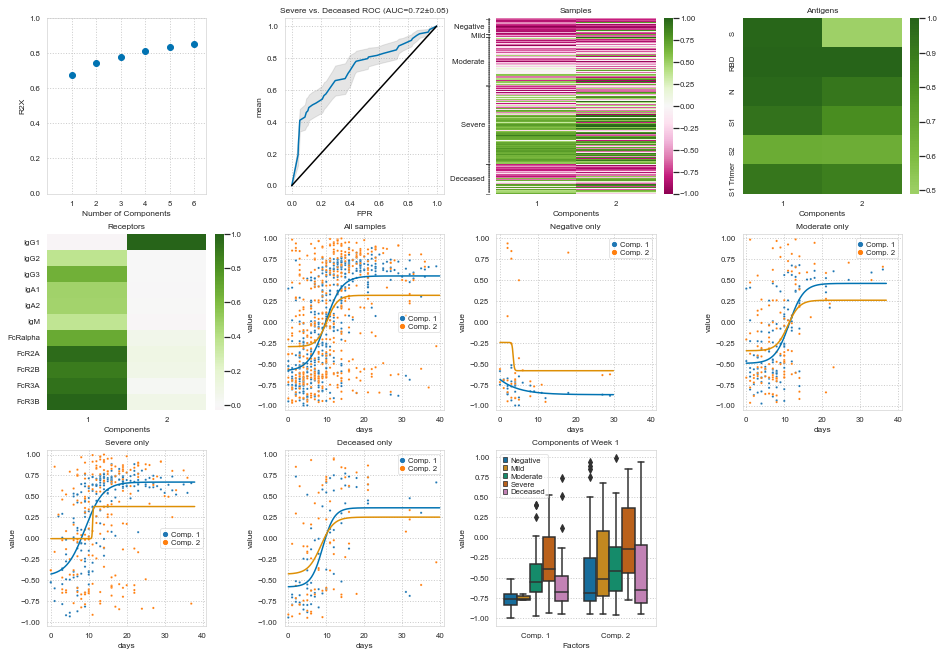

In [27]:
ax, f = getSetup((13, 9), (3, 4))
tfac = CMTFfacs[1]


# R2X by component plot (a)
CMTFR2X = np.array([calcR2X(f, tensor) for f in CMTFfacs])
print(CMTFR2X)
ax[0].scatter(comps, CMTFR2X, color="b")
ax[0].set_ylabel("R2X")
ax[0].set_xlabel("Number of Components")
ax[0].set_xticks([x for x in comps])
ax[0].set_xticklabels([x for x in comps])
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0.0, np.amax(comps) + 0.5)


# ROC curve (b)
roc_df, auc = COVIDpredict(tfac)
roc_sum = roc_df.groupby(['FPR'], as_index=False).agg({
    'TPR': ['mean', 'sem']})

sns.lineplot(x=roc_sum["FPR"], y=roc_sum["TPR"]
             ["mean"], color='b', ax=ax[1])
sns.lineplot(x=[0, 1], y=[0, 1], color="black", ax=ax[1])

tprs_upper = np.minimum(roc_sum["TPR"]["mean"] + roc_sum["TPR"]["sem"], 1)
tprs_lower = np.maximum(roc_sum["TPR"]["mean"] - roc_sum["TPR"]["sem"], 0)
ax[1].fill_between(roc_sum["FPR"], tprs_lower,
                   tprs_upper, color='grey', alpha=.2)
ax[1].set_title("Severe vs. Deceased ROC (AUC={}±{})".format(np.around(np.mean(auc), decimals=2),
                                                             np.around(sem(auc), decimals=2)))

components = [str(ii + 1) for ii in range(tfac.rank)]


# Heatmaps for components of each mode (c-e)
comp_plot(tfac.factors[0], components,
          list(pbsSubtractOriginal()['group']), "Samples", ax[2], True)
comp_plot(tfac.factors[1], components, antigenLabels, "Antigens", ax[3])
comp_plot(tfac.factors[2], components, receptorLabels, "Receptors", ax[4])


# Continuous time plots of components for different severities (f-j)
time_plot(tfac, ax[5])
time_plot(tfac, ax[6], condition="Negative")
time_plot(tfac, ax[7], condition="Moderate")
time_plot(tfac, ax[8], condition="Severe")
time_plot(tfac, ax[9], condition="Deceased")

# Factor weights of components separated by severity for week 1 (k)
df = time_components_df(tfac)
sns.boxplot(data=df.loc[df["week"] == 1, :],
            x="Factors", y="value", hue="group", ax=ax[10])
ax[10].set_title("Components of Week 1")
ax[10].legend(loc='upper left')

ax[11].axis("off")
